# DERs with channel effects

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from training_helpers import *

## Generate baselines

In [2]:
def calc_preambles(preamble_length=16, snr_range=np.arange(-10,11), cfo=10e3, num_iter=5000):
    
    preamble_seq = signal.max_len_seq(6)[0][:preamble_length]
    
    base_ders, expert_ders = test_baselines(signal.max_len_seq(6)[0][:preamble_length], snr_range=snr_range, 
                                            num_iter=num_iter, payload=128, signal_length=200, random_offset=True, 
                                            carrier_offset=cfo)
    
    result = {'base_ders': base_ders,
              'expert_ders': expert_ders,
              'snr_range': snr_range,
              'carrier_offset': cfo}
    
    print(f"saving to: baselines/length_{preamble_length}_cfo_{cfo}.pt")
    torch.save(result, f'baselines/length_{preamble_length}_cfo_{cfo}.pt')

In [3]:
preamble_lengths = [8, 16, 32]
snr_range=np.arange(-10,11)
cfos = [None, 10e3]


In [4]:
for length in preamble_lengths:
    for cfo in cfos:
        calc_preambles(preamble_length=length, snr_range=snr_range, cfo=cfo, num_iter=5000)

saving to: baselines/length_8_cfo_None.pt
saving to: baselines/length_8_cfo_10000.0.pt
saving to: baselines/length_16_cfo_None.pt
saving to: baselines/length_16_cfo_10000.0.pt
saving to: baselines/length_32_cfo_None.pt
saving to: baselines/length_32_cfo_10000.0.pt


In [5]:
base_ders_8 = torch.load('baselines/length_8_cfo_None.pt')['base_ders']
expert_ders_8 = torch.load('baselines/length_8_cfo_None.pt')['expert_ders']

base_ders_16 = torch.load('baselines/length_16_cfo_None.pt')['base_ders']
expert_ders_16 = torch.load('baselines/length_16_cfo_None.pt')['expert_ders']

base_ders_32 = torch.load('baselines/length_32_cfo_None.pt')['base_ders']
expert_ders_32 = torch.load('baselines/length_32_cfo_None.pt')['expert_ders']

base_ders_8_cfo10 = torch.load('baselines/length_8_cfo_10000.0.pt')['base_ders']
expert_ders_8_cfo10 = torch.load('baselines/length_8_cfo_10000.0.pt')['expert_ders']

base_ders_16_cfo10 = torch.load('baselines/length_16_cfo_10000.0.pt')['base_ders']
expert_ders_16_cfo10 = torch.load('baselines/length_16_cfo_10000.0.pt')['expert_ders']

base_ders_32_cfo10 = torch.load('baselines/length_32_cfo_10000.0.pt')['base_ders']
expert_ders_32_cfo10 = torch.load('baselines/length_32_cfo_10000.0.pt')['expert_ders']

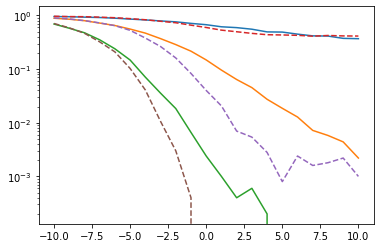

In [6]:
plt.semilogy(snr_range, base_ders_8)
plt.semilogy(snr_range, base_ders_16)
plt.semilogy(snr_range, base_ders_32)

plt.semilogy(snr_range, expert_ders_8, '--')
plt.semilogy(snr_range, expert_ders_16, '--')
plt.semilogy(snr_range, expert_ders_32, '--')

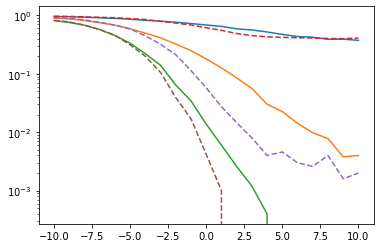

In [7]:
plt.semilogy(snr_range, base_ders_8_cfo10)
plt.semilogy(snr_range, base_ders_16_cfo10)
plt.semilogy(snr_range, base_ders_32_cfo10)

plt.semilogy(snr_range, expert_ders_8_cfo10, '--')
plt.semilogy(snr_range, expert_ders_16_cfo10, '--')
plt.semilogy(snr_range, expert_ders_32_cfo10, '--')

In [8]:
class preamble_detector(nn.Module):
    def __init__(self, num_layers, num_filters, width):
        super(preamble_detector, self).__init__()
        
        pad = int((width-1)/2)
        
        self.conv = torch.nn.Sequential()
        
        self.conv.add_module("conv0", torch.nn.Conv2d(1, num_filters, (2,width), 1, padding=(0,pad)))
        self.conv.add_module(f"relu0", torch.nn.ReLU())
        
        for i in range(num_layers-2):
            self.conv.add_module(f"conv{i+1}", nn.Conv2d(num_filters, num_filters, (1,width), 1, padding=(0,pad)))
            self.conv.add_module(f"relu{i+1}", torch.nn.ReLU())
        
        self.conv.add_module(f"conv_last", nn.Conv2d(num_filters, 1, 1, 1))

    def forward(self, x):

        # Do all convolutions
        x = self.conv(x)
        
        # Output only 1 dimension
        x = x.squeeze()

        return x

In [9]:
train_snr = 0
train_snrs = [10,5,0]
preamble_length = 32
preamble_lengths = [8, 16, 32]

num_models = 5
num_epochs = 50
batch_size = 32
lr = 0.001
reg = 0.001

add_cfo = True
max_cfo = 10e3
num_data = 8192

num_layers = 3
num_filters = 32
filter_width = 35

# loss_fn = nn.MSELoss()
loss_fn = nn.CrossEntropyLoss()
# loss_fns = [nn.MSELoss(), nn.CrossEntropyLoss()]

In [10]:
for test_cfo in [None, 10e3]:
    for preamble_length, train_snr in zip(preamble_lengths, train_snrs):
        models = torch.load(f"models/{preamble_length}_preamble_{train_snr}_cfo_True_{str(loss_fn).strip('()')}_reg_{reg}.pt")
        results = []
        for model in models:
            detector = preamble_detector(num_layers,num_filters,filter_width)
            detector.load_state_dict(model['weights'])

            ders = test_detector(detector, signal.max_len_seq(6)[0][:preamble_length], num_iter=5000, add_phase_offset=True, 
                                     carrier_offset=test_cfo, add_channel=False, snr_range=snr_range)

            result = {"ders": ders,
                      "model": model,
                      "snr_range": snr_range,
                      "train_snr": train_snr,
                      "test_cfo": test_cfo}

            results.append(result)
        torch.save(results, f"results/ders/{preamble_length}_cfo_{test_cfo}.pt")

In [11]:
def find_best_worst(results):
    best_acc = 0
    worst_acc = 100
    for idx, result in enumerate(results):
        mean_acc = np.mean(1-np.array(result['ders']))
        if mean_acc < worst_acc:
            worst_acc = mean_acc
            worst_idx = idx
        if mean_acc > best_acc:
            best_acc = mean_acc
            best_idx = idx
    return best_idx, worst_idx

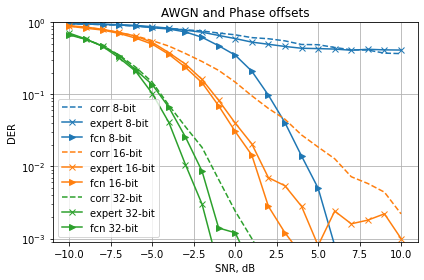

In [12]:
baselines = [base_ders_8, base_ders_16, base_ders_32]
experts = [expert_ders_8, expert_ders_16, expert_ders_32]

test_cfo = None
for i, (preamble_length, train_snr) in enumerate(zip(preamble_lengths, train_snrs)):
    results = torch.load(f"results/ders/{preamble_length}_cfo_{test_cfo}.pt")
    best, worst = find_best_worst(results)
    plt.semilogy(snr_range, baselines[i], f'--C{i}')
    plt.semilogy(snr_range, experts[i], f'-xC{i}')
    plt.semilogy(snr_range, results[best]['ders'], f'->C{i}')

plt.grid()
plt.ylim([0.0009, 1])
plt.xlabel('SNR, dB'); plt.ylabel('DER')
plt.title('AWGN and Phase offsets')
plt.legend(['corr 8-bit', 'expert 8-bit', 'fcn 8-bit', 
            'corr 16-bit', 'expert 16-bit', 'fcn 16-bit', 
            'corr 32-bit', 'expert 32-bit', 'fcn 32-bit'])
plt.tight_layout()
# plt.savefig('figures/fcn_awgn_ders.png', dpi=300)

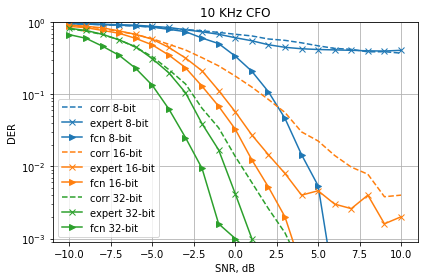

In [13]:
baselines_cfo10 = [base_ders_8_cfo10, base_ders_16_cfo10, base_ders_32_cfo10]
experts_cfo10 = [expert_ders_8_cfo10, expert_ders_16_cfo10, expert_ders_32_cfo10]

test_cfo = 10e3
for i, (preamble_length, train_snr) in enumerate(zip(preamble_lengths, train_snrs)):
    results = torch.load(f"results/ders/{preamble_length}_cfo_{test_cfo}.pt")
    best, worst = find_best_worst(results)
    plt.semilogy(snr_range, baselines_cfo10[i], f'--C{i}')
    plt.semilogy(snr_range, experts_cfo10[i], f'-xC{i}')
    plt.semilogy(snr_range, results[best]['ders'], f'->C{i}')

plt.grid()
plt.ylim([0.0009, 1])
plt.xlabel('SNR, dB'); plt.ylabel('DER')
plt.title('10 KHz CFO')
plt.legend(['corr 8-bit', 'expert 8-bit', 'fcn 8-bit', 
            'corr 16-bit', 'expert 16-bit', 'fcn 16-bit', 
            'corr 32-bit', 'expert 32-bit', 'fcn 32-bit'])
plt.tight_layout()
# plt.savefig('figures/fcn_cfo10_ders.png', dpi=300)

## Phase overfitting experiment

train single special model with no phase offset information

In [14]:
train_snr = 0
# train_snrs = [10,5,0]
preamble_length = 32
# preamble_lengths = [8, 16, 32]

num_models = 1
num_epochs = 50
batch_size = 32
lr = 0.001
reg = 0.001

add_cfo = True
max_cfo = 10e3
num_data = 8192

num_layers = 3
num_filters = 32
filter_width = 35

loss_fn = nn.CrossEntropyLoss()

random_phase_offsets = [True, False]

In [17]:
# training data
train_data, labels = gen_training_data(signal.max_len_seq(6)[0][:preamble_length], num_examples=num_data, snr=train_snr, add_phase_offset=False, 
                                       add_carrier_offset=add_cfo, max_carrier_offset=max_cfo)
train_data, labels = preprocess(train_data, labels)

train_dataset = torch.utils.data.TensorDataset(train_data, labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# validation data
val_data, val_labels = gen_training_data(signal.max_len_seq(6)[0][:preamble_length], num_examples=256, snr=train_snr, add_phase_offset=False,
                                         add_carrier_offset=add_cfo)
val_data, val_labels = preprocess(val_data, val_labels)

val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

models = []
print(f'Training models on {train_snr}dB SNR...')
for i in range(num_models):
    print(f'Model {i}...')
    torch.manual_seed(i)
    detector = preamble_detector(num_layers, num_filters, filter_width)
    detector.cuda()

    optimizer = optim.Adam(detector.parameters(), lr=lr, weight_decay=reg)

    detector, losses, val_losses, accs, val_accs = train_model(detector, optimizer, loss_fn, train_loader, val_loader, num_epochs=num_epochs)

    model_config = {"weights": detector.state_dict(),
                    "losses": losses,
                    "val_losses": val_losses,
                    "accs": accs,
                    "val_accs": val_accs,
                    "num_epochs": num_epochs,
                    "lr": lr}

    models.append(model_config)
torch.save(models, f"models/{preamble_length}_preamble_{num_data}_examples_{train_snr}_cfo_{add_cfo}_{str(loss_fn).strip('()')}_no_phase_offsets.pt")

Training models on 0dB SNR...
Model 0...


In [18]:
# This is a one time function, lifted from helper_functions, here we set phase offset to be a constant
def test_detector(detector, preamble_seq, snr_range, num_iter=1500, payload=128, signal_length=200, add_channel=False, 
             abs_phase=False, tau=None, plot=True, add_phase_offset=True, normalize=True, carrier_offset=None):

    nn_ers = np.zeros(len(snr_range),)
    
    if carrier_offset:
        offset_sine = np.exp(1j*2*np.pi*(carrier_offset/1e6)*np.arange(signal_length))
    
    for idx, snr in enumerate(snr_range):
        nn_err = float(0)
        for i in range(num_iter):
            
            # Create new frame
            ph = np.pi/3*180
            tau = np.random.randint(0,signal_length-payload-len(preamble_seq))

            my_frame = create_frame(preamble_seq, payload=payload, signal_length=signal_length, offset=tau)
    
            if add_phase_offset:
                my_frame = phase_offset(my_frame, offset=ph)
                
            if carrier_offset is not None:
                my_frame = my_frame*offset_sine

            if add_channel:
                gains = 1/np.sqrt(2)*(np.random.normal(0)+1j*np.random.normal(0))
                my_frame = gains*my_frame
                
            # Add noise
            my_frame = awgn(my_frame, snr)
            
            # normalize
            if normalize:
                my_frame = my_frame/np.max(np.abs(my_frame))

            # FCN prediction
            new_frame = np.expand_dims(np.vstack((my_frame.real, my_frame.imag)),axis=(0,1))
            new_frame = torch.tensor(new_frame).float()
            nn_output = detector(new_frame)

            y_nn = torch.argmax(nn_output)

            # Calculate if error
            nn_err = nn_err + (y_nn != tau)

        nn_ers[idx] = nn_err

    nn_ders = nn_ers/num_iter
        
    return nn_ders

def calculate_baseline(preamble_seq, snr_range=None, num_iter=1500, payload=128,
                       signal_length=200, add_phase_offset=0, carrier_offset=None,
                       sample_rate=1e6, add_channel=False):
    
    if snr_range is None:
        snr_range = np.arange(-15,10)
    
    preamble = np.where(preamble_seq < 1, -1+0j, 1+0j)

    corr_ers = np.zeros(len(snr_range),)
    
    if carrier_offset:
        offset_sine = np.exp(1j*2*np.pi*(carrier_offset/sample_rate)*np.arange(signal_length))

    for idx, snr in enumerate(snr_range):
        corr_err = float(0)
        for i in range(num_iter):

            # Create new frame with a random tau
            tau = np.random.randint(0,signal_length-payload-len(preamble_seq))
            my_frame = create_frame(preamble_seq, payload=payload, signal_length=signal_length, offset=tau)
            
            my_frame = phase_offset(my_frame, offset=add_phase_offset)
                
            if carrier_offset is not None:
                my_frame = my_frame*offset_sine
                
            if add_channel:
                gains = 1/np.sqrt(2)*(np.random.normal(0)+1j*np.random.normal(0))
                my_frame = gains*my_frame
                
            # Add noise
            my_frame = awgn(my_frame, snr)
            
            # Find peaks using correlation
            correlation = np.abs(np.correlate(my_frame, preamble, mode='valid'))
            y_corr = np.argmax(correlation)

            # Calculate if error
            corr_err = corr_err + (y_corr != tau)

        corr_ers[idx] = corr_err
  
    corr_ders = corr_ers/num_iter
        
    return corr_ders

In [19]:
models = torch.load(f"models/{preamble_length}_preamble_{num_data}_examples_{train_snr}_cfo_{add_cfo}_{str(loss_fn).strip('()')}_no_phase_offsets.pt")
results = []
for model in models:
    detector = preamble_detector(num_layers,num_filters,filter_width)
    detector.load_state_dict(model['weights'])

    ders_no_phase = test_detector(detector, signal.max_len_seq(6)[0][:preamble_length], num_iter=15000, add_phase_offset=False, 
                             carrier_offset=test_cfo, add_channel=False, snr_range=snr_range)
    
    ders_with_phase = test_detector(detector, signal.max_len_seq(6)[0][:preamble_length], num_iter=15000, add_phase_offset=True, 
                             carrier_offset=test_cfo, add_channel=False, snr_range=snr_range)

#     result = {"ders": ders,
#               "model": model,
#               "snr_range": snr_range,
#               "train_snr": train_snr,
#               "test_cfo": test_cfo}

#     results.append(result)
# torch.save(results, f"results/ders/{preamble_length}_cfo_{test_cfo}_no_phase_model_test_without_offset.pt")

In [20]:
base_ders_32_no_phase = calculate_baseline(signal.max_len_seq(6)[0][:32], snr_range=snr_range, num_iter=5000, 
                                           payload=128, signal_length=200, add_phase_offset=0, carrier_offset=None)

base_ders_32_with_phase = calculate_baseline(signal.max_len_seq(6)[0][:32], snr_range=snr_range, num_iter=5000, 
                                           payload=128, signal_length=200, add_phase_offset=np.pi/3*180, carrier_offset=None)

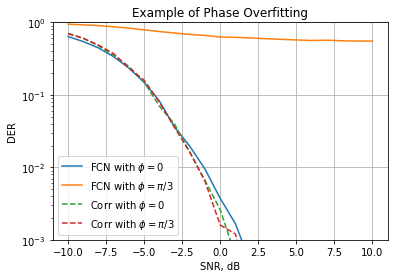

In [21]:
plt.semilogy(snr_range, ders_no_phase)
plt.semilogy(snr_range, ders_with_phase)
plt.semilogy(snr_range, base_ders_32_no_phase, '--')
plt.semilogy(snr_range, base_ders_32_with_phase, '--')
plt.ylim(0.001, 1)
plt.grid()
plt.xlabel('SNR, dB'); plt.ylabel('DER')
plt.title('Example of Phase Overfitting')
plt.legend([r'FCN with $\phi=0$', r'FCN with $\phi=\pi/3$', r'Corr with $\phi=0$', r'Corr with $\phi=\pi/3$'])
# plt.savefig('figures/phase_overfitting.png', dpi=300)